In [1]:
import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.nn.utils.spectral_norm as spectral_norm
import numpy as np
import matplotlib.pyplot as plt
import PIL
import collections
from sklearn.metrics import hinge_loss

In [2]:
def partition(img):
    target, inputs = img[0][:,:,:,0:256], img[0][:,:,:,256:]
    return inputs, target


def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    inp = np.clip(inp,0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
def scale(img, feature_range=(1,-1)):
    min, max = feature_range
    x = img * (max - min) + min
    return x

def to_data(x):
    if torch.cuda.is_available():
        x = x.cpu()
    x = x.numpy()
    x = ((x +1)*255 / (2)).astype(np.uint8) # rescale to 0-255
    return x

In [7]:
in_transforms = transforms.Compose([
    transforms.Resize((256,512)),
    transforms.ToTensor()
])
dataset = torchvision.datasets.ImageFolder('facades', transform=in_transforms)
dataloader = torch.utils.data.DataLoader(dataset, 1, num_workers=4)

In [8]:
imgs = next(iter(dataloader))
inputs, targets = partition(imgs)

torch.Size([1, 3, 256, 256])


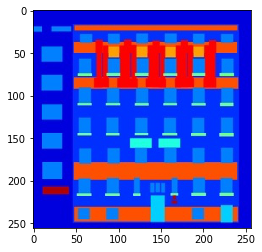

In [9]:
print(inputs.size())
out = torchvision.utils.make_grid(inputs, nrow=4)
imshow(out)


In [12]:
class conv(nn.Module):
    def __init__(self, in_chan, out_chan, kernel_size=3, stride=2, padding=1, instance_norm=True):
        super(conv, self).__init__()
        self.in_chan = in_chan
        self.out_chan = out_chan
        self.instance_norm = instance_norm
        self.conv1 = nn.Conv2d(in_chan, out_chan, kernel_size, stride, padding)
        torch.nn.init.xavier_normal_(self.conv1.weight)
        self.IN = nn.InstanceNorm2d(out_chan)
    def forward(self, x):
        x = self.conv1(x)
        if self.instance_norm:
            x = self.IN(x)
        return x

In [13]:
class Reparameterize(nn.Module):
    def __init__(self):
        super(Reparameterize, self).__init__()
        
    def forward(self, mean, log_var):
        b, h, w = mean.size()
        x = torch.randn(b, h, w)
        self.mean = nn.Parameter(data=mean)
        std_dev = log_var.mul(0.5).exp_()
        self.std = nn.Parameter(data = std_dev)
        return self.std * x.cuda() + self.mean

In [14]:
class KLD_Loss(nn.Module):
    def __init__(self, weight=0.5):
        super(KLD_Loss, self).__init__()
        self.weight = weight
        self.loss = None
    
    def forward(self, mean, log_var):
        self.loss = -self.weight * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
        return self.loss

In [62]:
class Hinge_Loss(nn.Module):
    def __init__(self):
        super(Hinge_Loss, self).__init__()
    
    def forward(self, inputs, for_real=True):
        if for_real:
            minval = torch.min(inputs - 1, torch.zeros(inputs.size()).cuda())
            loss = -torch.mean(minval)
        else:
            minval = torch.min(-inputs - 1, torch.zeros(inputs.size()).cuda())
            loss = -torch.mean(minval)
        return loss

In [15]:
class FeatureMatchingLoss(nn.Module):
    def __init__(self):
        super(FeatureMatchingLoss, self).__init__()
        
    def forward(self, real_img_feat, fake_img_feat):
        return F.mse_loss(real_img_feat, fake_img_feat)

In [16]:
class Perceptual_loss(nn.Module):
    def __init__(self):
        super(Perceptual_loss, self).__init__()        
        self.vgg = Vgg19().cuda()
        self.criterion = nn.L1Loss()
        self.weights = [1.0/32, 1.0/16, 1.0/8, 1.0/4, 1.0]        

    def forward(self, x, y):              
        x_vgg, y_vgg = self.vgg(x), self.vgg(y)
        loss = 0
        for i in range(len(x_vgg)):
            loss += self.weights[i] * self.criterion(x_vgg[i], y_vgg[i].detach())        
        return loss

In [17]:
class Vgg19(torch.nn.Module):
    def __init__(self, requires_grad=False):
        super(Vgg19, self).__init__()
        vgg_pretrained_features = torchvision.models.vgg19(pretrained=True).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        self.slice5 = torch.nn.Sequential()
        for x in range(2):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(2, 7):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(7, 12):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(12, 21):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        for x in range(21, 30):
            self.slice5.add_module(str(x), vgg_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X):
        h_relu1 = self.slice1(X)
        h_relu2 = self.slice2(h_relu1)        
        h_relu3 = self.slice3(h_relu2)        
        h_relu4 = self.slice4(h_relu3)        
        h_relu5 = self.slice5(h_relu4)                
        out = [h_relu1, h_relu2, h_relu3, h_relu4, h_relu5]
        return out

In [18]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = conv(3, 64)
        self.conv2 = conv(64, 128)
        self.conv3 = conv(128, 256)
        self.conv4 = conv(256, 512)
        self.conv5 = conv(512, 512)
        self.conv6 = conv(512, 512)
        self.mean = None
        self.log_var = None
        self.mean_linear = nn.Linear(8192, 256)
        self.var_linear = nn.Linear(8192, 256)
        self.Reparam = Reparameterize()
        
        #self.init_weights()
        
    def forward(self, x):
        eps = np.random.standard_normal()
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        x = F.leaky_relu(self.conv4(x))
        x = F.leaky_relu(self.conv5(x))
        x = F.leaky_relu(self.conv5(x))
        conv_out = x.view(-1, 1, 8192)
        self.mean = self.mean_linear(conv_out)
        self.log_var = self.var_linear(conv_out)
        self.noise = self.Reparam(self.mean, self.log_var)
        return self.noise
    

In [19]:
E = Encoder()
E = E.cuda()
E(inputs.cuda()).size()

torch.Size([1, 1, 256])

In [20]:
class Spade(nn.Module):
    def __init__(self, num_features):
        super(Spade, self).__init__()
        self.bn = nn.BatchNorm2d(num_features)
        self.conv1 = nn.Conv2d(3, 128, 3, 1, 1)
        self.mean_conv = nn.Conv2d(128, num_features, 3, 1, 1)
        self.var_conv = nn.Conv2d(128, num_features, 3, 1, 1)
        torch.nn.init.xavier_normal_(self.conv1.weight)
        torch.nn.init.xavier_normal_(self.mean_conv.weight)
        torch.nn.init.xavier_normal_(self.var_conv.weight)
        
    def forward(self, in_bn, semant):
        bn_out = self.bn(in_bn)
        h, w = bn_out.size()[-2], bn_out.size()[-1]
        semant = F.interpolate(semant, size = (h, w), mode='nearest')
        conv1_out = F.relu(self.conv1(semant))
        mean_conv = self.mean_conv(conv1_out)
        var_conv = self.var_conv(conv1_out)
        out = bn_out + mean_conv * var_conv
        return out

In [21]:
class Spade_ResBlk(nn.Module):
    def __init__(self, num_features, out_features):
        super(Spade_ResBlk, self).__init__()
        self.spade_1 = Spade(num_features)
        self.spade_2 = Spade(num_features)
        self.skip_spade = Spade(num_features)
        self.conv1 = nn.Conv2d(num_features, num_features, 3, 1, 1)
        torch.nn.init.xavier_normal_(self.conv1.weight)
        self.upsample = nn.ConvTranspose2d(num_features, out_features, 4, 2, 1)
        torch.nn.init.xavier_normal_(self.upsample.weight)
    
    def forward(self, x, semant):
        start = x
        x = F.relu(self.spade_1(x, semant))
        x = self.conv1(x)
        x = F.relu(self.spade_2(x, semant))
        x = self.conv1(x)
        skip = self.conv1(F.relu(self.skip_spade(start, semant)))
        return self.upsample(x + skip)

In [22]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.last_IN = nn.InstanceNorm2d(512)
        self.conv1 = spectral_norm(conv(6, 64, 4, instance_norm=False).conv1)
        self.conv2 = spectral_norm(conv(64, 128, 4).conv1)
        self.conv3 = spectral_norm(conv(128, 256, 4).conv1)
        self.conv4 = spectral_norm(conv(256, 512, 4).conv1)
        self.conv5 = spectral_norm(conv(512, 1, 4, instance_norm=False).conv1)

                
    def forward(self, inputs, target):
        x = torch.cat([inputs.float(), target], dim=1)
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        x = F.leaky_relu(self.conv4(x))
        ft_match = F.leaky_relu(self.last_IN(x))
        x = self.conv5(ft_match)
        return x, ft_match

In [23]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.encoder = Encoder()
        self.linear = nn.Linear(256, 16384)
        self.spadeblk1 = Spade_ResBlk(1024, 1024)
        self.spadeblk2 = Spade_ResBlk(1024, 1024)
        self.spadeblk3 = Spade_ResBlk(1024, 1024)
        self.spadeblk4 = Spade_ResBlk(1024, 512)
        self.spadeblk5 = Spade_ResBlk(512, 256)
        self.spadeblk6 = Spade_ResBlk(256, 128)
        self.spadeblk7 = Spade_ResBlk(128, 64)
        
        
        self.last_conv = nn.Conv2d(64, 3, 3, 2, 1)
        
    def forward(self, target, semant):
        noise = self.encoder(target)
        x = self.linear(noise)
        x = x.view(-1, 1024, 4, 4)
        x = self.spadeblk1(x, semant)
        x = self.spadeblk2(x, semant)
        x = self.spadeblk3(x, semant)
        x = self.spadeblk4(x, semant)
        x = self.spadeblk5(x, semant)
        x = self.spadeblk6(x, semant)
        x = self.spadeblk7(x, semant)
        x = torch.tanh(self.last_conv(x))
        return x
    

In [24]:
def checkpoint(D, G, epoch):
    torch.save('D_spade_{}.pth'.format(epoch) , D.state_dict())
    torch.save('G_spade._{}pth'.format(epoch) , G.state_dict())

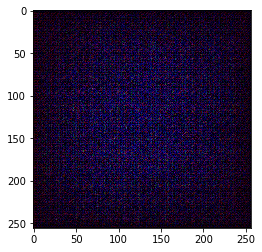

In [25]:
G = Generator()
G = G.cuda()
imshow(G(inputs.cuda(), targets.cuda())[0].detach().cpu())

In [63]:
def train_gan(D, G, dataloader, epochs=200):
    ######----Define losses----#####
    Feature_match_loss = FeatureMatchingLoss()
    Perceptual_error = Perceptual_loss()
    Kld_loss = KLD_Loss()
    hinge_loss = Hinge_Loss()
    
    cuda = torch.cuda.is_available()
    g_optim = optim.Adam(G.parameters(), lr=0.0001, betas=(0, 0.999))
    d_optim = optim.Adam(D.parameters(), lr=0.0004, betas=(0, 0.999))
    log_every = 10
    if cuda:
        D = D.cuda()
        G = G.cuda()
    
    for e in range(1, epochs+1):
        for i, data in enumerate(dataloader):
            inputs, targets = partition(data)
            if cuda:
                inputs = inputs.cuda()
                targets = targets.cuda()
            
            #### ---Train Discriminator--- ###
            d_optim.zero_grad()
            real_D_output, _ = D(inputs, targets)
            real_D_loss = hinge_loss(real_D_out)
            fake_G_out = G(targets, inputs)
            fake_D_out, _ = D(inputs, fake_G_out.detach())
            fake_D_loss = hinge_loss(fake_D_out, for_real=False)
            total_D_loss = fake_D_loss + real_D_loss
            total_D_loss.backward()
            d_optim.step()
            
            #### ---Train Generator ---###
            g_optim.zero_grad()
            _, real_ft = D(inputs, targets)
            fake_G_out = G(targets, inputs)
            mean, log_var = G.encoder.mean, G.encoder.log_var
            kld_loss = Kld_loss(mean, log_var)
            perceptual_loss = Perceptual_error(inputs, targets)
            fake_D_out, fake_ft = D(inputs, fake_G_out)
            feature_match_loss = Feature_match_loss(real_ft, fake_ft)
            G_hinge_criterion = -torch.mean(fake_D_out)
            total_G_loss = kld_loss + perceptual_loss + feature_match_loss + G_hinge_criterion
            g_optim.zero_grad()
            total_G_loss.backward()
            g_optim.step()
            
            if i % log_every == 0:
                #checkpoint(D, G, e)
                print('Epoch {}/{} D_loss: {:.4f} G_loss: {:.4f}'.format(e, epochs, total_D_loss, total_G_loss))

In [55]:
D, G = Discriminator(), Generator()

In [64]:
train_gan(D, G, dataloader)

Epoch 1/200 D_loss: 1.9198 G_loss: 4.0859


RuntimeError: CUDA out of memory. Tried to allocate 16.00 MiB (GPU 0; 15.90 GiB total capacity; 15.16 GiB already allocated; 5.88 MiB free; 46.50 MiB cached)

In [ ]:
torch.cuda.empty_cache()

In [57]:
!nvidia-smi

Fri Apr 12 23:28:24 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.104      Driver Version: 410.104      CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    40W / 250W |  15903MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [65]:
imshow(G(inputs.cuda(), targets.cuda())[0].detach().cpu())

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.90 GiB total capacity; 15.17 GiB already allocated; 1.88 MiB free; 34.88 MiB cached)

In [ ]:
def download(filename):
  """Downloads the file to the user's local disk via a browser download action.
  Args:
    filename: Name of the file on disk to be downloaded.
  Raises:
    OSError: if the file cannot be found.
  """

    if not _os.path.exists(filename):
    msg = 'Cannot find file: {}'.format(filename)
    if _six.PY2:
        raise OSError(msg)
    else:
        raise FileNotFoundError(msg)  # pylint: disable=undefined-variable

    started = _threading.Event()
    port = _portpicker.pick_unused_port()
